# Diarization with Speaker Change

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization-speaker-change](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization-speaker-change).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

We are going to compare `conformer-base` and `vggvox-v2`.

In [2]:
model_conformer = malaya_speech.speaker_vector.deep_model('conformer-base')
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2')

### Load audio sample

In [3]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [4]:
# just going to take 60 seconds
y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [5]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

In [6]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

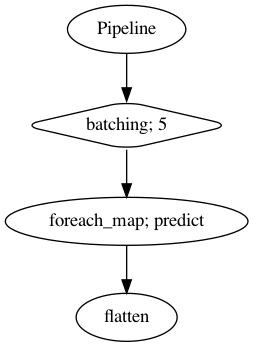

In [7]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [8]:
%%time

result = p(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 1min 1s, sys: 34.1 s, total: 1min 35s
Wall time: 23.3 s


dict_keys(['batching', 'predict', 'flatten'])

In [9]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

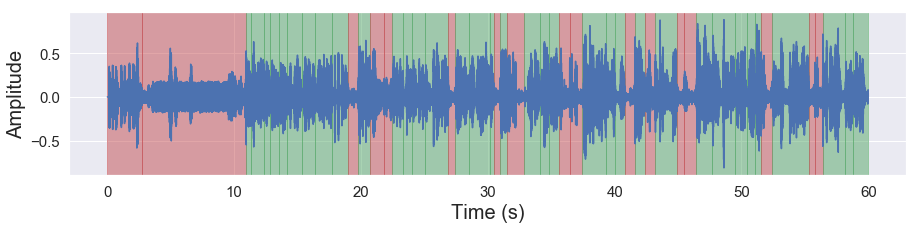

In [10]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

### Load Spectral Clustering

In [11]:
from spectralcluster import SpectralClusterer

clusterer = SpectralClusterer(
    min_clusters=3,
    max_clusters=100,
)

### Use speaker change detection

Speaker change detection is an important part of speaker diarization systems. It aims at finding the boundaries between speech turns of two different speakers. Read more about Speaker Change at https://malaya-speech.readthedocs.io/en/latest/load-speaker-change.html

In [12]:
speakernet = malaya_speech.speaker_change.deep_model('speakernet')

In [13]:
frames_speaker_change = list(malaya_speech.utils.generator.frames(y, 500, sr))
probs_speakernet = [(frame, speakernet.predict_proba([frame])[0, 1]) for frame in frames_speaker_change]

In [14]:
nested_grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)
splitted_speakernet = malaya_speech.speaker_change.split_activities(nested_grouped_vad, probs_speakernet)

In [16]:
result_diarization_sc_conformer = malaya_speech.diarization.clustering(
    vad_results = grouped_vad, 
    speaker_vector = model_conformer,
    model = clusterer,
)
result_diarization_sc_conformer[:5]

[(<malaya_speech.model.frame.Frame at 0x177624350>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17e8d3890>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17e8d3190>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x177207a10>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17761bf50>, 'speaker 0')]

In [17]:
result_diarization_splitted_sc_conformer = malaya_speech.diarization.clustering(
    vad_results = splitted_speakernet, 
    speaker_vector = model_conformer,
    model = clusterer,
)
result_diarization_splitted_sc_conformer[:5]

[(<malaya_speech.model.frame.Frame at 0x17f367510>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17d086bd0>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17d086c10>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17d086c90>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17d086cd0>, 'speaker 0')]

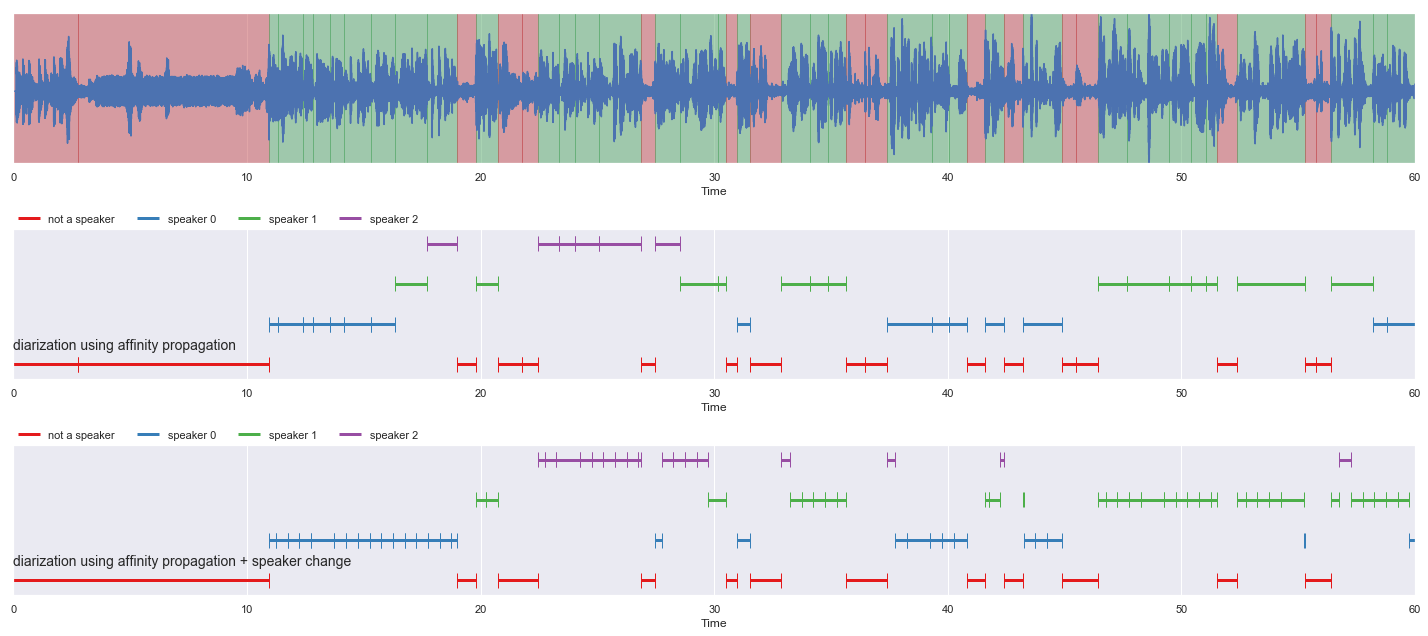

In [18]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_conformer, 
                                                      'diarization using affinity propagation', ax = ax[1],
                                                     x_text = 0.01)
malaya_speech.extra.visualization.plot_classification(result_diarization_splitted_sc_conformer, 
                                                      'diarization using affinity propagation + speaker change', 
                                                      ax = ax[2],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()